In [1]:
# Import required libraries

import requests
import tweepy
import pandas as pd
import json
import datetime 
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import seaborn as sns

## Gather

In [3]:
# Download the tweet image predictions tsv file via requests library

url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)
with open(url.split('/')[-1], mode = 'wb') as file:
    file.write(response.content)

In [3]:
# Read `image_predictions.tsv` file

predict_dog = pd.read_csv('image-predictions.tsv', sep = '\t')

In [4]:
# Read `twitter archive enhanced.csv` file to get tweet ids for API

twitter_df = pd.read_csv('twitter-archive-enhanced.csv')
# extract tweet ids only for use in API

tweet_id = twitter_df['tweet_id']

In [5]:
# Authenticate Tweepy API

consumer_key = ''
consumer_secret = ''
access_token = ''
access_secret = ''

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth, wait_on_rate_limit = True, wait_on_rate_limit_notify = True,
                 parser=tweepy.parsers.JSONParser())

In [6]:
# Get tweet JSON data using tweet_id via Tweepy 

tweet_json = []
error_list = []
for i in tweet_id:
    try:
        tweet = api.get_status(i, tweet_mode = 'extended')
        tweet_json.append(tweet)
    except:
        error_list.append(i)
        continue

Rate limit reached. Sleeping for: 306
Rate limit reached. Sleeping for: 350


In [7]:
# Write JSON data to tweet_json.txt file with each tweet's JSON data on its own line

with open('tweet_json.txt', 'w') as outfile:
    json.dump(tweet_json, outfile, indent = True)

In [8]:
# Read tweet_json.txt file into a pandas data frame 

pd_json = pd.read_json('tweet_json.txt', orient = 'columns')

In [9]:
# Extract only needed columns (tweet_id, favorite_count, retweet_count)
# Save it to tweet_json

tweet_json = pd_json[['id','favorite_count','retweet_count']]

# Assess

### Visual Assessment

In [10]:
# display predict_dog table

predict_dog.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [12]:
# display predict_dog table

predict_dog.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [13]:
# display twitter_df table
twitter_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [14]:
# display twitter_df table

twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [15]:
# display tweet_json table

tweet_json.head()

,id,favorite_count,retweet_count
0,892420643555336193,38663,8548
1,892177421306343426,33127,6286
2,891815181378084864,24939,4166
3,891689557279858688,42030,8677
4,891327558926688256,40191,9435


In [16]:
# display tweet_json table

tweet_json.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2344 entries, 0 to 2343
Data columns (total 3 columns):
id                2344 non-null int64
favorite_count    2344 non-null int64
retweet_count     2344 non-null int64
dtypes: int64(3)
memory usage: 73.2 KB


### Programmatic Assessment

In [17]:
# display predict_dog table

predict_dog.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [18]:
# display twitter_df table

twitter_df.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [19]:
# display tweet_json table

tweet_json.describe()

,id,favorite_count,retweet_count
count,2.344000e+03,2344.000000,2344.000000
mean,7.422890e+17,8036.373720,3009.416809
std,6.835057e+16,12095.406735,5007.177541
min,6.660209e+17,0.000000,0.000000
25%,6.783704e+17,1399.000000,602.750000
50%,7.187854e+17,3524.000000,1401.500000
75%,7.986989e+17,9935.000000,3502.000000
max,8.924206e+17,142826.000000,76995.000000


### Quality
##### `twitter_df` table
- some tweets was deleted or invalid (2356 instead of 2345) found in `error_list`
- `tweet_id` column type is integer althogh it should be string
- `timestamp` column type is object meaning string but it should be datetime
- `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id`
    and `retweeted_status_timestamp` columns have values rather than `NaN`  
    that is not the criteria of the analysis we need only original tweets no retweet or replies
    
- `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id`
   and `retweeted_status_timestamp` don't add useful information to our dataset no more

##### `predict_dog` table
- `tweet_id` column type is integer although it should be string 
- invalid records because some tweets are deleted from the archive
- not all images are for dogs! some images are for other animals

##### `tweet_json` table
- `id` column type is integer although it should be string
- `id` column name is not consistent with other tables same column names

### Tidiness
##### `twitter_df` table
- `time stamp` column should be two separate columns for `date` and `time`

##### `predict_dog` table
- the whole table should be merged with `twitter_df` table 

##### `tweet_json` table
- the whole table should be merged with `twitter_df` table 

In [20]:
# Make a copy of the datasets to work with and clean

twitter_df_clean = twitter_df.copy()
predict_dog_clean = predict_dog.copy()
tweet_json_clean = tweet_json.copy()

# Clean
### Define
### Quality 
##### `twitter_df_clean` table
- remove all records with ids in `error_list`

### Code

In [21]:
# remove all records with ids in `error_list`

for record in error_list:
    twitter_df_clean.drop(twitter_df_clean[twitter_df_clean.tweet_id == record].index, inplace = True)

### Test

In [22]:
# check if any record with id from error_list still exists!

twitter_df_clean['tweet_id'].isin(error_list).value_counts()

False    2344
Name: tweet_id, dtype: int64

### Define
### Quality
##### `twitter_df_clean` table
- convert `tweet_id` column to string

### Code

In [23]:
# Convert tweet_id column to string

twitter_df_clean['tweet_id'] = twitter_df_clean['tweet_id'].astype(str)

### Test

In [24]:
# check the column type is converted correctly 

twitter_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2344 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2344 non-null object
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2344 non-null object
source                        2344 non-null object
text                          2344 non-null object
retweeted_status_id           170 non-null float64
retweeted_status_user_id      170 non-null float64
retweeted_status_timestamp    170 non-null object
expanded_urls                 2285 non-null object
rating_numerator              2344 non-null int64
rating_denominator            2344 non-null int64
name                          2344 non-null object
doggo                         2344 non-null object
floofer                       2344 non-null object
pupper                        2344 non-null object
puppo                         2344 non-null object
dtypes: float64(4), int64(2), o

### Define
### Quality
##### `twitter_df_clean` table
- convert `timestamp` column to datetime

### Code

In [25]:
# convert `timestamp` column to datetime

twitter_df_clean['timestamp'] = pd.to_datetime(twitter_df_clean['timestamp'])

### Test

In [90]:
# check that `timestamp` column is converted correctly

twitter_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2096 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2096 non-null object
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     2096 non-null datetime64[ns]
source                        2096 non-null object
text                          2096 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2093 non-null object
rating_numerator              2096 non-null int64
rating_denominator            2096 non-null int64
name                          2096 non-null object
doggo                         2096 non-null object
floofer                       2096 non-null object
pupper                        2096 non-null object
puppo                         2096 non-null object
dtypes: datetime64[ns](1), floa

### Define
### Quality
##### `twitter_df_clean` table
- remove any values rather than nulls in  `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`,  
  `retweeted_status_user_id` and `retweeted_status_timestamp` columns

### Code

In [74]:
# get rows index with values in 'in_reply_to_status_id'

irtsid = twitter_df_clean['in_reply_to_status_id'][twitter_df_clean.in_reply_to_status_id.notnull()].index

In [76]:
# drop rows with index with values in the above list

twitter_df_clean.drop(irtsid, inplace = True)

In [77]:
# get rows index with values in 'in_reply_to_user_id' column

irtuid = twitter_df_clean['in_reply_to_user_id'][twitter_df_clean.in_reply_to_user_id.notnull()].index

In [78]:
# drop rows with index with values in the above list

twitter_df_clean.drop(irtuid, inplace = True)

In [79]:
# get rows index with values in 'retweeted_status_id' column

rsid = twitter_df_clean['retweeted_status_id'][twitter_df_clean.retweeted_status_id.notnull()].index

In [80]:
# drop rows with index with values in the above list

twitter_df_clean.drop(rsid, inplace = True)

In [81]:
# get rows index with values in 'retweeted_status_user_id' column

rsuid = twitter_df_clean['retweeted_status_user_id'][twitter_df_clean.retweeted_status_user_id.notnull()].index

In [82]:
# drop rows with index with values in the above list

twitter_df_clean.drop(rsuid, inplace = True)

In [83]:
# get rows index with values in 'retweeted_status_timestamp' column

rsts = twitter_df_clean['retweeted_status_timestamp'][twitter_df_clean.retweeted_status_timestamp.notnull()].index

In [84]:
# drop rows with index with values in the above list

twitter_df_clean.drop(rsts, inplace = True)

### Test

In [85]:
# check if any non null values exist in in_reply_to_status_id column

twitter_df_clean['in_reply_to_status_id'][twitter_df_clean.in_reply_to_status_id.notnull()]

Series([], Name: in_reply_to_status_id, dtype: float64)

In [86]:
# check if any non null values exist in in_reply_to_user_id column

twitter_df_clean['in_reply_to_user_id'][twitter_df_clean.in_reply_to_user_id.notnull()]

Series([], Name: in_reply_to_user_id, dtype: float64)

In [87]:
# check if any non null values exist in retweeted_status_id column

twitter_df_clean['retweeted_status_id'][twitter_df_clean.retweeted_status_id.notnull()]

Series([], Name: retweeted_status_id, dtype: float64)

In [88]:
# check if any non null values exist in retweeted_status_user_id column

twitter_df_clean['retweeted_status_user_id'][twitter_df_clean.retweeted_status_user_id.notnull()]

Series([], Name: retweeted_status_user_id, dtype: float64)

In [89]:
# check if any non null values exist in retweeted_status_timestamp column

twitter_df_clean['retweeted_status_timestamp'][twitter_df_clean.retweeted_status_timestamp.notnull()]

Series([], Name: retweeted_status_timestamp, dtype: object)

### Define
### Quality
##### `twitter_df_clean` table
- drop `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`,  
  `retweeted_status_user_id` and `retweeted_status_timestamp` columns

### Code

In [91]:
# drop 'in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id',
# 'retweeted_status_user_id' and 'retweeted_status_timestamp' columns from `twitter_df_clean` table

twitter_df_clean.drop(columns = ['in_reply_to_status_id', 'in_reply_to_user_id',
                                 'retweeted_status_id', 'retweeted_status_user_id',
                                 'retweeted_status_timestamp'], inplace = True)

### Test

In [92]:
# look at the data frame to see the columns is removed

twitter_df_clean.tail()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2351,666049248165822465,2015-11-16 00:24:50,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,2015-11-16 00:04:52,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,2015-11-15 23:21:54,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,2015-11-15 23:05:30,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None
2355,666020888022790149,2015-11-15 22:32:08,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,https://twitter.com/dog_rates/status/666020888...,8,10,None,None,None,None,None


### Define
### Quality 
##### `predict_dog_clean` table
- convert `tweet_id` column type to string

### Code

In [96]:
# convert `tweet_id` column type to string

predict_dog_clean['tweet_id'] = predict_dog_clean['tweet_id'].astype(str)

### Test

In [97]:
# check column type is correct

predict_dog_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null object
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


### Define
### Quality 
##### `predict_dog_clean` table
- remove all records with `tweet_id` in `error_list`

### Code

In [98]:
# remove all records with `tweet_id` in `error_list`

for record in error_list:
    predict_dog_clean.drop(predict_dog_clean[predict_dog.tweet_id == record].index, inplace = True)

/home/ahmed/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


### Test

In [99]:
# check if any record with id from error_list still exists!

predict_dog_clean['tweet_id'].isin(error_list).value_counts()

False    2068
Name: tweet_id, dtype: int64

### Define
### Quality 
##### `predict_dog_clean` table
- remove all non dog records by keeping only the records where at least `p1_dog` or `p2_dog` or`p3_dog` is `True`

### Code

In [100]:
# remove all non-dog records by keeping only the records where at least `p1_dog` or `p2_dog' or `p3_dog` are `True`

predict_dog_clean.drop(predict_dog_clean[(predict_dog_clean.p1_dog == False)
                                         & (predict_dog_clean.p2_dog == False)
                                         & (predict_dog_clean.p3_dog == False)].index, inplace = True)

### Test

In [101]:
# Check if any non-dog record exists!

predict_dog_clean['tweet_id'].isin(non_dogs).value_counts()

False    1745
Name: tweet_id, dtype: int64

In [102]:
# reset all indeces in all tables to keep every thing in a consistent manner

twitter_df_clean = twitter_df_clean.reset_index()
predict_dog_clean = predict_dog_clean.reset_index()

In [103]:
# drop all `index` columns in all tables for consistency

twitter_df_clean.drop(columns = ['index'], inplace = True)
predict_dog_clean.drop(columns = ['index'], inplace = True)

### Define
### Quality 
##### `tweet_json_clean` table
- convert `id` column type to string

### Code

In [104]:
# convert `id` column type to string

tweet_json_clean['id'] = tweet_json_clean['id'].astype(str)

### Test

In [105]:
# check the column type is converted correctly 

tweet_json_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2344 entries, 0 to 2343
Data columns (total 3 columns):
id                2344 non-null object
favorite_count    2344 non-null int64
retweet_count     2344 non-null int64
dtypes: int64(2), object(1)
memory usage: 73.2+ KB


### Define
### Quality 
##### `tweet_json_clean` table
- rename `id` column to `tweet_id` for consistency with other tables

### Code

In [106]:
# rename `id` column to `tweet_id` for consistency with other tables

tweet_json_clean = tweet_json_clean.rename(columns = {'id' : 'tweet_id'})

### Test

In [107]:
# check the column name is changed 

tweet_json_clean.head()

,tweet_id,favorite_count,retweet_count
0,892420643555336193,38663,8548
1,892177421306343426,33127,6286
2,891815181378084864,24939,4166
3,891689557279858688,42030,8677
4,891327558926688256,40191,9435


### Define
### Tidiness
##### `twitter_df_clean` table
- split `time stamp` column to two separate columns `date` and `time`

### Code

In [108]:
# First, convert the `timestamp` column type to datetime

twitter_df_clean['timestamp'] = pd.to_datetime(twitter_df_clean['timestamp'])

In [109]:
# second, split `time stamp` column to two separate columns `date` and `time`

twitter_df_clean['date'] = [d.date() for d in twitter_df_clean['timestamp']]
twitter_df_clean['time'] = [d.time() for d in twitter_df_clean['timestamp']]

In [131]:
# Third, convert `date` to datetime type

twitter_df_clean['date'] = pd.to_datetime(twitter_df_clean['date'])

In [112]:
# finally, drop the `timestamp` column as it is no longer needed

twitter_df_clean.drop(columns = ['timestamp'], inplace = True)

### Test

In [132]:
# check type of `timestamp` column is datetime

twitter_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1665 entries, 0 to 1664
Data columns (total 26 columns):
tweet_id              1665 non-null object
source                1665 non-null object
text                  1665 non-null object
expanded_urls         1665 non-null object
rating_numerator      1665 non-null int64
rating_denominator    1665 non-null int64
name                  1665 non-null object
doggo                 1665 non-null object
floofer               1665 non-null object
pupper                1665 non-null object
puppo                 1665 non-null object
date                  1665 non-null datetime64[ns]
time                  1665 non-null object
favorite_count        1665 non-null int64
retweet_count         1665 non-null int64
jpg_url               1665 non-null object
img_num               1665 non-null int64
p1                    1665 non-null object
p1_conf               1665 non-null float64
p1_dog                1665 non-null bool
p2                    1665 non-

In [114]:
# check the columns are created correctly

twitter_df_clean.head()

,tweet_id,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,date,time
0,892420643555336193,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None,2017-08-01,16:23:56
1,892177421306343426,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None,2017-08-01,00:17:27
2,891815181378084864,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None,2017-07-31,00:18:03
3,891689557279858688,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None,2017-07-30,15:58:51
4,891327558926688256,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None,2017-07-29,16:00:24


In [115]:
# check `timestamp` column is dropped 

twitter_df_clean.tail()

,tweet_id,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,date,time
2091,666049248165822465,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None,2015-11-16,00:24:50
2092,666044226329800704,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None,2015-11-16,00:04:52
2093,666033412701032449,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None,2015-11-15,23:21:54
2094,666029285002620928,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None,2015-11-15,23:05:30
2095,666020888022790149,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,https://twitter.com/dog_rates/status/666020888...,8,10,None,None,None,None,None,2015-11-15,22:32:08


### Define
### Tidiness
##### `tweet_json_clean` table
- merge `tweet_json_clean` table with `twitter_df_clean` table 

### Code

In [116]:
# merge `tweet_json_clean` table with `twitter_df_clean` table 

twitter_df_clean = pd.merge(twitter_df_clean, tweet_json_clean, on = 'tweet_id')

### Test

In [117]:
# check the merge is done correctly

twitter_df_clean.head()

,tweet_id,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,date,time,favorite_count,retweet_count
0,892420643555336193,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None,2017-08-01,16:23:56,38663,8548
1,892177421306343426,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None,2017-08-01,00:17:27,33127,6286
2,891815181378084864,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None,2017-07-31,00:18:03,24939,4166
3,891689557279858688,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None,2017-07-30,15:58:51,42030,8677
4,891327558926688256,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None,2017-07-29,16:00:24,40191,9435


### Define
### Tidiness
##### `predict_dog_clean` table
- merge `predict_dog_clean` table with `twitter_df_clean` table 

### Code

In [118]:
# merge `predict_dog_clean` table with `twitter_df_clean` table 

twitter_df_clean = pd.merge(twitter_df_clean, predict_dog_clean, on = 'tweet_id')

### Test

In [119]:
# check the merge is done correctly

twitter_df_clean.head()

,tweet_id,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892177421306343426,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,...,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
1,891815181378084864,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,...,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2,891689557279858688,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,...,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
3,891327558926688256,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,...,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
4,891087950875897856,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,...,1,Chesapeake_Bay_retriever,0.425595,True,Irish_terrier,0.116317,True,Indian_elephant,0.076902,False


In [133]:
# writing cleaned data to a master csv file

twitter_df_clean.to_csv('twitter_archive_master.csv', index=False)

# Ask Questions

1- what dog breed is most present in the dataset ?

2- what is the range of rating scores through the dataset (out of 10) ?

3- which year has the most tweets for the hashtag ?

4- is the rating score related to number of tweet's favorites ?

5- which dog breed has the most tweet favorites and retweets ?

# Exploratory Data Analysis

In [134]:
# load data

twitter_master = pd.read_csv('twitter_archive_master.csv')

In [136]:
# explore twitter_master dataset

twitter_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1665 entries, 0 to 1664
Data columns (total 26 columns):
tweet_id              1665 non-null int64
source                1665 non-null object
text                  1665 non-null object
expanded_urls         1665 non-null object
rating_numerator      1665 non-null int64
rating_denominator    1665 non-null int64
name                  1665 non-null object
doggo                 1665 non-null object
floofer               1665 non-null object
pupper                1665 non-null object
puppo                 1665 non-null object
date                  1665 non-null object
time                  1665 non-null object
favorite_count        1665 non-null int64
retweet_count         1665 non-null int64
jpg_url               1665 non-null object
img_num               1665 non-null int64
p1                    1665 non-null object
p1_conf               1665 non-null float64
p1_dog                1665 non-null bool
p2                    1665 non-null obje

### Question 1: what dog breed is most present in the dataset ?

In [123]:
# find the most present dog breed

twitter_master['p1'].value_counts().head()

golden_retriever      137
Labrador_retriever     94
Pembroke               88
Chihuahua              78
pug                    54
Name: p1, dtype: int64

##### So, we can see that `golden retriever` dog is the most probable present breed in the dataset with 137 times appeared 

### Question 2: what is the range of rating scores through the dataset (out of 10) ?

In [124]:
# look at the dataset values for `rating_numerator` column

twitter_master.describe()

,tweet_id,rating_numerator,rating_denominator,favorite_count,retweet_count,img_num,p1_conf,p2_conf,p3_conf
count,1.665000e+03,1665.000000,1665.000000,1665.000000,1665.000000,1665.000000,1665.000000,1665.000000,1.665000e+03
mean,7.394956e+17,11.387988,10.469069,9197.616216,2767.682282,1.214414,0.605897,0.137296,6.127248e-02
std,6.803661e+16,7.491315,6.345835,12989.553402,4835.367467,0.574108,0.266472,0.101600,5.194375e-02
min,6.660209e+17,0.000000,2.000000,80.000000,13.000000,1.000000,0.044333,0.000010,2.160900e-07
25%,6.775479e+17,10.000000,10.000000,2109.000000,623.000000,1.000000,0.379055,0.054787,1.593830e-02
50%,7.141414e+17,11.000000,10.000000,4335.000000,1392.000000,1.000000,0.607401,0.121375,4.981050e-02
75%,7.931959e+17,12.000000,10.000000,11483.000000,3146.000000,1.000000,0.853284,0.199287,9.466370e-02
max,8.921774e+17,165.000000,150.000000,142826.000000,76995.000000,4.000000,0.999984,0.467678,2.734190e-01


In [126]:
# look at the value counts to have an image in mind of the data

twitter_master['rating_numerator'].value_counts()

12     420
10     358
11     352
13     221
9      132
8       68
7       32
14      21
6       16
5       14
4        7
3        5
2        2
144      1
1        1
165      1
24       1
26       1
27       1
44       1
45       1
50       1
60       1
75       1
80       1
84       1
88       1
99       1
121      1
0        1
Name: rating_numerator, dtype: int64

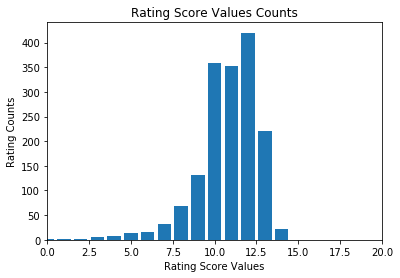

In [128]:
# plot values Vs. counts to see the range of values 
% matplotlib inline

vals =   [0,1,2,3,4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,24,26,27,44,45,50,60,75,80,84,88,99,121,144,165]
counts = [1,1,2,5,7,14,16,32,68,132,358,352,420,221,21, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
                               
plt.bar(vals, counts, align = 'center')
plt.xlabel('Rating Score Values')
plt.xlim(xmin = 0, xmax = 20)
plt.ylabel('Rating Counts')
plt.title('Rating Score Values Counts')
plt.show()

##### We can see that rating score ranges from 1 to 165 with highest peak at 12 .  
##### of course they are funny numbers but the center of the plot is telling the truth!
##### most people rated between 10 and 12 out of 10 

In [130]:
twitter_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1665 entries, 0 to 1664
Data columns (total 26 columns):
tweet_id              1665 non-null int64
source                1665 non-null object
text                  1665 non-null object
expanded_urls         1665 non-null object
rating_numerator      1665 non-null int64
rating_denominator    1665 non-null int64
name                  1665 non-null object
doggo                 1665 non-null object
floofer               1665 non-null object
pupper                1665 non-null object
puppo                 1665 non-null object
date                  1665 non-null object
time                  1665 non-null object
favorite_count        1665 non-null int64
retweet_count         1665 non-null int64
jpg_url               1665 non-null object
img_num               1665 non-null int64
p1                    1665 non-null object
p1_conf               1665 non-null float64
p1_dog                1665 non-null bool
p2                    1665 non-null obje

In [137]:
# convert `date` column to datetime to work on it

twitter_master['date'] = pd.to_datetime(twitter_master['date'])

### Question 3: which year has the most tweets for the hashtag ?

In [138]:
# pick only years of each date to work on later

year = []

for r in twitter_master.index:
    
    year.append(twitter_master['date'][r].date().year)    

Text(0.5,1,'Tweets about hashtag across years')

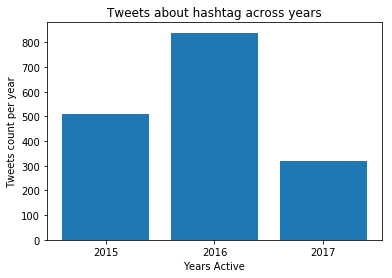

In [139]:
# plot years Vs. count of tweets per year

Cont = Counter(year)
occur = Cont[2015], Cont[2016], Cont[2017]
occur
years = ["2015", "2016", "2017"]

plt.bar(years, occur)
plt.xlabel('Years Active')
plt.ylabel('Tweets count per year')
plt.title('Tweets about hashtag across years')

##### We can see that most tweets are in 2016 with nearly 800 tweets 
##### also 2015 is nearly 500  and 2017 are a bit above 300 tweets
##### So, we can say that 2016 was the hottest year for on that trend!

### Question 4: is the rating score related to number of tweet's favorites ?

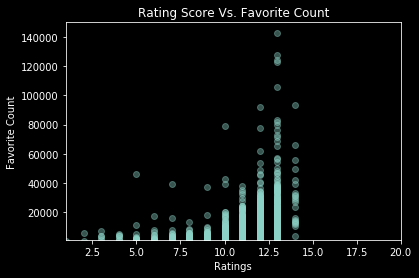

In [150]:
# let's plot a scatter plot and find out!

plt.scatter(twitter_master['rating_numerator'], twitter_master['favorite_count'], alpha = 0.4)
plt.xlim(xmin = 1, xmax = 20)
plt.ylim(ymin = 1000, ymax = 150000)
plt.xlabel('Ratings')
plt.ylabel('Favorite Count')
plt.title('Rating Score Vs. Favorite Count')
plt.style.use('dark_background')
plt.show()

In [142]:
# find the correaltion coeffecient between favorite count and rating scores

twitter_master['rating_numerator'].corr(twitter_master['favorite_count'])


0.07497603406879587

##### As we saw in the plot, there is a weak positive correaltion here 
##### and the programmatic calculations ensured that relation

### Question5: which dog breed has the most tweet favorites and retweets ?

In [143]:
# pick only needed columns 

breed_merged = twitter_master[['p1', 'favorite_count', 'retweet_count']]

#rename p1 column to dog_breed

breed_merged.rename(columns = {"p1": "dog_breed"}, inplace = True)

/home/ahmed/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [144]:
# look at our new dataframe

breed_merged.head()

,dog_breed,favorite_count,retweet_count
0,Chihuahua,33127,6286
1,Chihuahua,24939,4166
2,paper_towel,42030,8677
3,basset,40191,9435
4,Chesapeake_Bay_retriever,20157,3124


In [145]:
# group unique dog_breed and the sum of favorites and retweets for each breed

by_dog_breed = breed_merged.groupby('dog_breed')['favorite_count', 'retweet_count'].sum()

In [146]:
# reshape the dataframe to work on it

by_dog_breed = by_dog_breed.reset_index()

In [147]:
# look at what we have done!

by_dog_breed.head()

,dog_breed,favorite_count,retweet_count
0,Afghan_hound,50597,17298
1,African_hunting_dog,1716,1167
2,Airedale,61746,16130
3,American_Staffordshire_terrier,95717,27643
4,Angora,92203,31543


In [148]:
# look for how many unique breed exists

len(by_dog_breed['dog_breed'].unique())

214

In [149]:
by_dog_breed['dog_breed'].values

array(['Afghan_hound', 'African_hunting_dog', 'Airedale',
       'American_Staffordshire_terrier', 'Angora', 'Appenzeller',
       'Arabian_camel', 'Arctic_fox', 'Australian_terrier',
       'Bedlington_terrier', 'Bernese_mountain_dog', 'Blenheim_spaniel',
       'Border_collie', 'Border_terrier', 'Boston_bull',
       'Brabancon_griffon', 'Brittany_spaniel', 'Cardigan',
       'Chesapeake_Bay_retriever', 'Chihuahua', 'Dandie_Dinmont',
       'Doberman', 'Egyptian_cat', 'English_setter', 'English_springer',
       'EntleBucher', 'Eskimo_dog', 'French_bulldog', 'German_shepherd',
       'German_short-haired_pointer', 'Gordon_setter', 'Great_Dane',
       'Great_Pyrenees', 'Greater_Swiss_Mountain_dog', 'Ibizan_hound',
       'Irish_setter', 'Irish_terrier', 'Irish_water_spaniel',
       'Italian_greyhound', 'Japanese_spaniel', 'Labrador_retriever',
       'Lakeland_terrier', 'Leonberg', 'Lhasa', 'Loafer', 'Maltese_dog',
       'Mexican_hairless', 'Newfoundland', 'Norfolk_terrier',
      

#### There are 214 unique dog breed! 
#### that's alot of points to plot!

In [151]:
# I will aggregate the breeds to 8 groups only according to AKC 

Sporting = ['Brittany_spaniel', 'Chesapeake_Bay_retriever', 'English_setter', 'English_springer',
            'German_short-haired_pointer', 'Gordon_setter', 'Irish_setter', 'Irish_water_spaniel', 
            'Labrador_retriever', 'flat-coated_retriever', 'curly-coated_retriever', 'golden_retriever', 
            'Sussex_spaniel', 'Weimaraner', 'Welsh_springer_spaniel', 'clumber',
            'cocker_spaniel', 'vizsla']

Hound = ['Afghan_hound', 'Ibizan_hound', 'Norwegian_elkhound', 'Rhodesian_ridgeback',
      'Saluki', 'Scottish_deerhound', 'basenji', 'basset',
      'beagle', 'black-and-tan_coonhound', 'bloodhound', 'bluetick',
      'borzoi', 'redbone', 'whippet']

Working = ['Bernese_mountain_dog', 'Doberman', 'Great_Dane', 'Great_Pyrenees',
        'Greater_Swiss_Mountain_dog', 'Leonberg', 'Newfoundland', 'Rottweiler', 
        'Saint_Bernard', 'Samoyed', 'Siberian_husky', 'Tibetan_mastiff',
        'boxer', 'bull_mastiff', 'giant_schnauzer', 'kuvasz',
        'kelpie', 'malamute', 'standard_schnauzer']


Terrier = ['Airedale', 'American_Staffordshire_terrier', 'Australian_terrier', 'Bedlington_terrier',
        'Border_terrier', 'Dandie_Dinmont', 'Irish_terrier', 'Lakeland_terrier',
        'Norfolk_terrier', 'Norwich_terrier', 'Scotch_terrier', 'Yorkshire_terrier',
        'West_Highland_white_terrier', 'wire-haired_fox_terrier', 'soft-coated_wheaten_terrier',
        'Staffordshire_bullterrier', 'cairn', 'miniature_schnauzer']

Toy = ['Blenheim_spaniel', 'Brabancon_griffon', 'Chihuahua', 'Italian_greyhound',
       'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Pomeranian',
       'Shih-Tzu', 'silky_terrier', 'miniature_pinscher', 'papillon',
       'pug', 'toy_terrier', 'toy_poodle']


Non_Sporting = ['French_bulldog', 'Eskimo_dog', 'Lhasa', 'Tibetan_terrier',
                'chow','dalmatian', 'keeshond', 'schipperke',
                'miniature_poodle', 'standard_poodle']


Herding = ['Border_collie', 'Cardigan', 'EntleBucher', 'German_shepherd',
           'Old_English_sheepdog', 'Pembroke', 'Shetland_sheepdog', 'briard',
           'collie', 'groenendael', 'malinois']


Companion = ['Boston_bull']

Misc = ['Appenzeller', 'Mexican_hairless', 'Walker_hound']

breed_merged['dog_group'] = 'None'

for r in range(len(breed_merged)-1):
    
    if breed_merged['dog_breed'][r] in Sporting:
        
        breed_merged['dog_group'][r] = 'Sporting'
    
    elif breed_merged['dog_breed'][r] in Hound:
        
        breed_merged['dog_group'][r] = 'Hound'
        
    elif breed_merged['dog_breed'][r] in Working:
        
        breed_merged['dog_group'][r] = 'Working'
    
    elif breed_merged['dog_breed'][r] in Terrier:
        
        breed_merged['dog_group'][r] = 'Terrier'
    
    elif breed_merged['dog_breed'][r] in Toy:
        
        breed_merged['dog_group'][r] = 'Toy'
        
    elif breed_merged['dog_breed'][r] in Non_Sporting:
        
        breed_merged['dog_group'][r] = 'Non_Sporting'
 
    elif breed_merged['dog_breed'][r] in Herding:
        
        breed_merged['dog_group'][r] = 'Herding'

    elif breed_merged['dog_breed'][r] in Companion:
        
        breed_merged['dog_group'][r] = 'Companion'
        
    elif breed_merged['dog_breed'][r] in Misc:
        
        breed_merged['dog_group'][r] = 'Misc'
        
    else:
        breed_merged['dog_group'][r] = 'None'   


/home/ahmed/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ahmed/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ahmed/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2862: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ah

In [152]:
# let's group the data again but now by group of breeds!

by_dog_group = breed_merged.groupby('dog_group')['favorite_count', 'retweet_count'].sum()

In [153]:
# check the aggregation is done right!

by_dog_group = by_dog_group.reset_index()

In [154]:
# now look at the unique labels for dog groups

len(by_dog_group['dog_group'].unique())

10

In [155]:
by_dog_group.describe()

,favorite_count,retweet_count
count,1.000000e+01,1.000000e+01
mean,1.531403e+06,4.608191e+05
std,1.151145e+06,3.543652e+05
min,5.434000e+04,1.487600e+04
25%,8.627570e+05,2.289940e+05
50%,1.637150e+06,4.778820e+05
75%,1.936228e+06,6.160030e+05
max,3.979206e+06,1.198312e+06


##### Whooa! 10 labels instead of 110!
##### that's a whole of work 

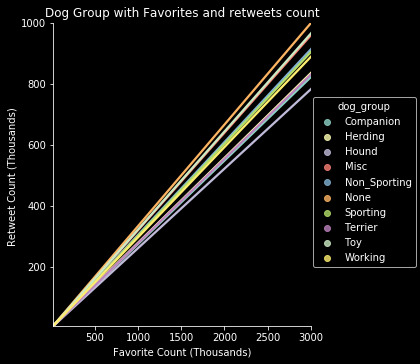

In [156]:
# let's plot those to have a look which dog group is topping the hashtag!


sns.lmplot(x="favorite_count", y="retweet_count", hue="dog_group", data=by_dog_group)
plt.xlim(20, 3000)
plt.ylim(6, 1000)
plt.xlabel('Favorite Count (Thousands)')
plt.ylabel('Retweet Count (Thousands) ')
plt.title('Dog Group with Favorites and retweets count')
plt.show()

#### we can see obviously that `Sporting` dog group is catching the eyes of fans!
#### as its line goes diagonally to the right hand side
#### meaning it has the most retweets and favorites

In [157]:
max(by_dog_group.favorite_count), max(by_dog_group.retweet_count)

(3979206, 1198312)

In [158]:
by_dog_group

,dog_group,favorite_count,retweet_count
0,Companion,54340,14876
1,Herding,1925782,535700
2,Hound,802864,209191
3,Misc,95856,30625
4,Non_Sporting,1381126,420064
5,None,1893173,629982
6,Sporting,3979206,1198312
7,Terrier,1042436,288403
8,Toy,2199538,706972
9,Working,1939710,574066
